# Few-shot классификация

[Ссылка на исходный Colab-блокнот](https://colab.research.google.com/github/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb)



Реализуем
[Prototypical Networks](https://arxiv.org/abs/1703.05175). Это любимый метод
многих исследователей few-shot обучения (~2000 цитирований за 3 года), потому что 1) он хорошо работает и 2) его легко понять и реализовать.

## Изучение Prototypical Networks
Сначала установим [необходимый репозиторий GitHub](https://github.com/sicara/easy-few-shot-learning) и импортируем некоторые пакеты.

In [1]:
!pip install easyfsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 4.8 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

Теперь нам нужен набор данных. Будем использовать [Omniglot](https://github.com/brendenlake/omniglot), популярный бенчмарк, похожий на MNIST,
для few-shot классификации. Он содержит 1623 символа из 50 различных алфавитов. Каждый символ был написан
20 разными людьми.

Датасет входит в пакет `torchvision`, поэтому его легко загрузить
и работать с ним.

In [3]:
image_size = 28

# Примечание: background=True выбирает обучающий набор, background=False выбирает тестовый набор
# Это наименования из оригинальной статьи

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Изображения Omniglot имеют 1 канал, но наша модель ожидает 3-канальные изображения
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

100%|██████████| 9.46M/9.46M [00:00<00:00, 175MB/s]
100%|██████████| 6.46M/6.46M [00:00<00:00, 115MB/s]


Попробуем разобраться, что такое few-shot классификация. Проще говоря, в задаче few-shot классификации у вас есть размеченный набор поддержки - support set (который действует
как каталог) и набор запросов - query set. Для каждого изображения из набора запросов мы хотим предсказать метку (label) из
меток, присутствующих в наборе поддержки. Модель few-shot классификации должна использовать информацию из
набора поддержки для классификации изображений запросов. Мы говорим *few-shot*, когда набор поддержки содержит очень
мало изображений для каждой метки (обычно менее 10). Рисунок ниже показывает задачу классификации 3-way 2-shot. "3-way" означает "3 различных класса", а "2-shot" означает "2 примера на класс".
Мы ожидаем, что модель, которая никогда не видела ни одного сенбернара, мопса или лабрадора во время обучения, успешно
предскажет метки запросов. Набор поддержки - это единственная информация, которую модель имеет относительно того, что такое сенбернар,
мопс или лабрадор.

![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

Большинство методов few-shot классификации являются *метрическими*. Эти методы работают в два этапа: 1) используют CNN для проецирования как
изображений поддержки, так и запросов в пространство признаков, и 2) классифицируют изображения запросов, сравнивая их с изображениями поддержки.
Если в пространстве признаков изображение ближе к мопсам, чем к лабрадорам и сенбернарам, мы делаем предположение, что
это мопс.

Отсюда у нас есть две задачи:

1. Найти хорошее пространство признаков. Для этого нужны сверточные сети. CNN - это в общем смысле функция, которая принимает изображение на входе и возвращает представление (или *embedding*) этого изображения в заданном пространстве признаков. Задача здесь состоит в том, чтобы иметь CNN, которая будет
проецировать изображения одного класса в представления, которые близки друг к другу, даже если она не обучалась
на объектах этого класса.
2. Найти хороший способ сравнения представлений в пространстве признаков. Это задача Prototypical Networks.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)

Из набора поддержки Prototypical Networks вычисляют прототип для каждого класса, который является средним всех эмбеддингов
изображений поддержки из этого класса. Затем каждый запрос просто классифицируется как ближайший прототип в пространстве признаков,
относительно евклидова расстояния.

Если вы хотите узнать больше о том, как это работает, автор блокнота объясняет это
[здесь](https://www.sicara.fr/blog-technique/few-shot-image-classification-meta-learning).
Теперь давайте перейдем к коду.
В коде ниже мы просто определяем Prototypical Networks как модуль torch с методом `forward()`.
Можно заметить 2 вещи.

1. Инициализируем `PrototypicalNetworks` с помощью *backbone*. Это экстрактор признаков, о котором мы говорили.
Здесь используется в качестве backbone ResNet18, предобученный на ImageNet, с отрезанной головой и замененной на слой `Flatten`.
Выход backbone для входного изображения будет 512-мерным вектором признаков.
2. Метод forward принимает не один входной тензор, а 3 - для предсказания меток изображений запросов
нам также нужны изображения поддержки и метки в качестве входных данных модели.

In [4]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Предсказывает метки запросов, используя размеченные изображения поддержки.
        """
        # Извлекаем признаки изображений поддержки и запросов
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Выводим количество различных классов из меток набора поддержки
        n_way = len(torch.unique(support_labels))
        # Прототип i - это среднее всех экземпляров признаков, соответствующих меткам == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Вычисляем евклидово расстояние от запросов до прототипов
        dists = torch.cdist(z_query, z_proto)

        # Домножим на -1 для преобразования этих расстояний в оценки классификации
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Теперь у нас есть модель. Обратите внимание, что мы использовали предобученный экстрактор признаков,
поэтому наша модель уже должна работать. Давайте проверим это.

Ниже мы создаем загрузчик данных, который будет подавать задачи few-shot классификации в нашу модель.
Но обычный PyTorch dataloader будет подавать батчи изображений без учета
их меток или того, являются ли они поддержкой или запросом. В нашем случае нам нужны 2 специфические функции.

1. Нам нужны изображения, равномерно распределенные между заданным количеством классов.
2. Нам нужно разделить их между наборами поддержки и запросов.

Для первой задачи написан пользовательский сэмплер: он сначала выбирает `n_way` классов из набора данных,
затем выбирает `n_shot + n_query` изображений для каждого класса (всего `n_way * (n_shot + n_query)`
изображений в каждом батче).
Для второй задачи есть пользовательская функция collate для замены встроенной PyTorch `collate_fn`.
Эта функция подает каждый батч как комбинацию из 5 элементов:

1. изображения поддержки
2. метки поддержки от 0 до `n_way`
3. изображения запросов
4. метки запросов от 0 до `n_way`
5. отображение каждой метки в `range(n_way)` на ее истинный идентификатор класса в наборе данных
(это не используется моделью, но очень полезно для нас, чтобы знать, какой истинный класс)

Вы можете видеть, что в PyTorch DataLoader - это в основном комбинация сэмплера (sampler), набора данных (dataset) и функции collate
(и некоторой магии multiprocessing): сэмплер говорит, какие элементы получить, набор данных говорит, как их получить, а
функция collate говорит, как представить эти элементы вместе. Если вы хотите углубиться в эти пользовательские объекты,
они находятся [здесь](https://github.com/sicara/easy-few-shot-learning/tree/master/easyfsl).

In [5]:
N_WAY = 5  # Количество классов в задаче
N_SHOT = 5  # Количество изображений на класс в наборе поддержки
N_QUERY = 10  # Количество изображений на класс в наборе запросов
N_EVALUATION_TASKS = 100

# Сэмплеру нужен набор данных (dataset) с методом "get_labels"
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Мы создали загрузчик данных (dataloader), который будет подавать нам задачи 5-way 5-shot (самый распространенный вариант).
Давайте посмотрим на наш набор данных.

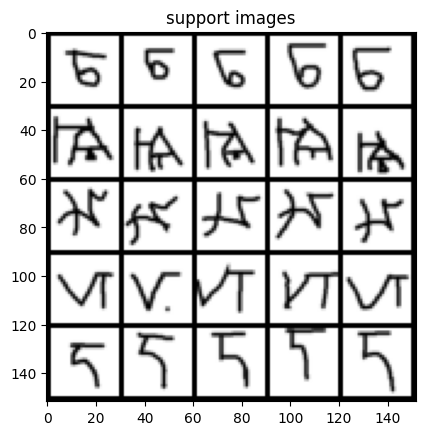

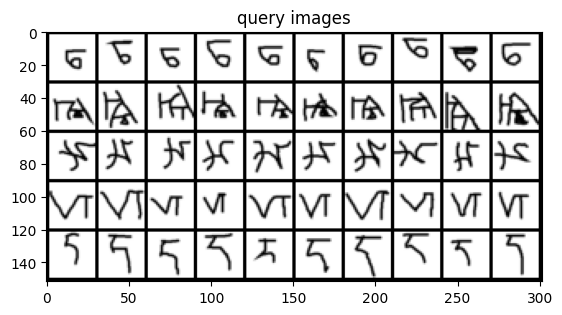

In [6]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

Для обоих наборов поддержки и запросов у вас должна быть одна строка для каждого класса.

Как наша модель работает на этой задаче?

In [7]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Tibetan/character17
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Mongolian/character15
Old_Church_Slavonic_(Cyrillic)/character36 / Old_Church_Slavonic_(Cyrillic)/character36
Old_Church_Slavonic_(Cyrillic)/character36 / Old_Church_Slavonic_(Cyrillic)/character36
Old_Church_Slavonic_(Cyrillic)/character36 / Old_Church_Slavonic_(Cyrillic)/character36
Old_Church_Slavonic_(Cyrillic)/character36 / Old_Church_Slavonic_(Cyrillic)/character36
Old_Church_Slavonic_(Cyrillic)/character36 / Old_Church_Slavonic_(Cyrillic)/character36
Old_Church_Slavonic_(Cyrillic)/character36 / Old_Church_Slavonic_(Cyrillic)/c

Выглядит неплохо: помните, что модель обучалась на совершенно других изображениях и видела только 5 примеров для каждого класса!

Теперь давайте посмотрим более точно, насколько точна наша модель.

In [8]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Возвращает количество правильных предсказаний меток запросов и общее количество предсказаний.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # Мы будем считать все и вычислять соотношение в конце
    total_predictions = 0
    correct_predictions = 0

    # режим eval влияет на поведение некоторых слоев (таких как batch normalization или dropout)
    # no_grad() говорит torch не хранить в памяти весь вычислительный граф (так легче)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:04<00:00, 22.56it/s]

Model tested on 100 tasks. Accuracy: 86.24%


Без обучения на изображениях Omniglot и всего с 5 примерами на класс мы достигаем около 86% точности!


Теперь узнаем, как **мета-обучить эту модель**, чтобы получить еще лучшие результаты.

## Обучение мета-обучающего алгоритма (Training a meta-learning algorithm)

Давайте применим "фоновые" (background) изображения Omniglot в качестве обучающего набора. Здесь мы подготавливаем загрузчик данных из 40 000 задач few-shot классификации,
на которых мы будем обучать нашу модель. Алфавиты, используемые в обучающем наборе, полностью отделены от тех, что используются в тестовом наборе.
Это гарантирует, что во время тестирования модель будет классифицировать символы, которые не использовались во время обучения.

Обратите внимание, что мы не создаем здесь валидационный набор, чтобы сохранить этот блокнот кратким,
но помните, что **это не лучшая практика**, и вы всегда должны использовать валидацию при обучении модели.

Примечание: В настоящее время есть ошибка в PyTorch DataLoader для пользователей Mac/Windows, которая делает невозможным использование нескольких воркеров с пользовательской функцией `get_labels`.
Вы можете установить `num_workers=0`, чтобы избежать этой проблемы при создании экземпляра DataLoader в следующей ячейке.
Подробнее об [этой проблеме](https://github.com/sicara/easy-few-shot-learning/issues/51).

In [9]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

Сохраним ту же модель. Таким образом, наши веса будут предобучены на ImageNet. Если вы хотите начать обучение с нуля, установите `pretrained=False` в определении ResNet.

Ниже мы определяем нашу функцию потерь и оптимизатор (перекрестная энтропия и Adam), а также метод `fit`.
Этот метод принимает задачу классификации на входе (набор поддержки и набор запросов). Он предсказывает метки набора запросов
на основе информации из набора поддержки; затем он сравнивает предсказанные метки с истинными метками запросов,
и это дает нам значение потерь. Затем он использует эти потери для обновления параметров модели. Это *мета-обучающий цикл* (*meta-training loop*).

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

Для обучения модели будем итерироваться по большому количеству случайно сгенерированных задач few-shot классификации,
и позволим методу `fit` обновлять нашу модель после каждой задачи. Это называется **эпизодическое обучение** **(episodic training)**.

In [11]:
# Обучите модель самостоятельно с помощью этой ячейки

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 40000/40000 [42:51<00:00, 15.55it/s, loss=0.403]


Теперь посмотрим, стала ли наша модель лучше.

In [12]:
evaluate(test_loader)

100%|██████████| 100/100 [00:04<00:00, 24.54it/s]

Model tested on 100 tasks. Accuracy: 80.50%


## Что мы узнали?

- Что такое Prototypical Network и как реализовать его в 15 строках кода.
- Как использовать Omniglot для оценки few-shot моделей
- Как использовать пользовательские объекты PyTorch для выборки батчей в форме задач few-shot классификации.
- Как использовать мета-обучение для обучения few-shot алгоритма.


[Репозиторий с реализацией методов few-shot обучения](https://github.com/sicara/easy-few-shot-learning)

